# **Set Up**

In [ ]:
# import necessary libraries

import pandas as pd
import numpy as np
import os
import glob

# for modeling
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import joblib

# for scoring
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

# for visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
file_path = '/content/gdrive/Shareddrives/Hackathon/Data localized/location'

# **Data Pre-processing**

In [ ]:
#Fetch file names
files = os.path.join(file_path, "*.csv")
files = glob.glob(files)

#Contatenate all files in one dataframe
df = pd.concat(map(pd.read_csv, files), ignore_index=True)

# Process dates
df['datemut'] = pd.to_datetime(df['datemut'])
df['day'] = df['datemut'].dt.day
df['month'] = df['datemut'].dt.month
df['year'] = df['datemut'].dt.year
df.set_index('datemut', inplace=True)

# drop unnecessary columns
columns_dropped =  ['Unnamed: 0','Unnamed: 0.1','codservch', 'refdoc']
df = df.drop(columns_dropped, axis=1)

# filter new apartment (in line with testset)
df = df[(df['vefa']==1) & (df['libtypbien'].str.contains('APPARTEMENT'))]

# filter out NaN values for 'valeurfonc' (14 lines)
df = df[df['valeurfonc'].notnull()]

# filter out 0,1 values for 'stabi' 
df = df.drop(df[df['sbati'] < 10].index)


# **Feature Engineering**

Analysis of numerical variables

In [ ]:
# check numerical variables
num_var = ['sterr','nblocdep','nbdispo', 'nblot', 'nbcomm', 'nbsection', 'nbpar', 'nbsuf','nblocmut','nblocapt','sbati','latitude','longitude','valeurfonc']
df[num_var].describe()

,sterr,nblocdep,nbdispo,nblot,nbcomm,nbsection,nbpar,nbsuf,nblocmut,nblocapt,sbati,latitude,longitude,valeurfonc
count,19685.000000,19685.000000,19685.000000,19685.000000,19685.000000,19685.000000,19685.000000,19685.000000,19685.000000,19685.000000,19685.000000,19685.000000,19685.000000,1.968500e+04
mean,3.642926,1.103785,1.001676,2.367844,1.000152,1.002388,1.041351,0.018542,2.192482,1.088697,62.772212,48.838817,2.367568,3.034232e+05
std,150.112660,1.641778,0.040911,3.267843,0.012344,0.048806,0.231657,0.181751,3.073423,1.588434,83.273946,0.125798,0.210626,3.466715e+05
min,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,12.000000,48.262463,1.596562,1.000000e+00
25%,0.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,0.000000,2.000000,1.000000,43.000000,48.786366,2.243212,1.860000e+05
50%,0.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,0.000000,2.000000,1.000000,59.000000,48.851480,2.366860,2.420000e+05
75%,0.000000,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,0.000000,2.000000,1.000000,70.000000,48.919434,2.499698,3.300000e+05
max,17768.000000,73.000000,2.000000,180.000000,2.000000,2.000000,9.000000,8.000000,146.000000,75.000000,3819.000000,49.156392,3.283849,1.377828e+07


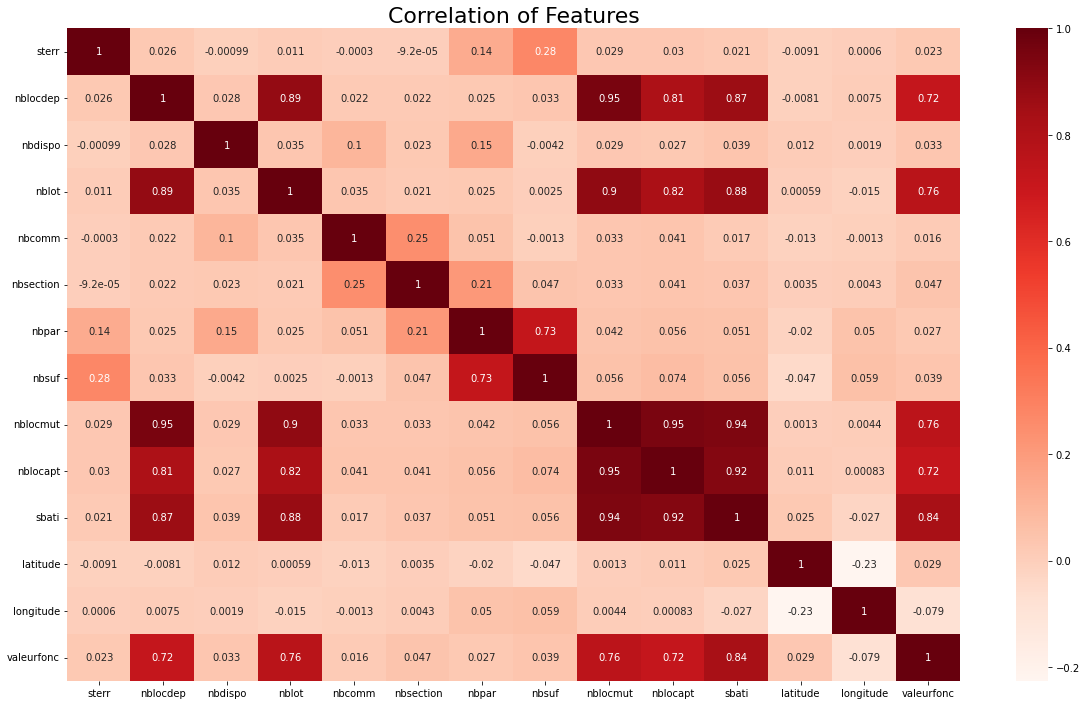

In [ ]:
# check correlation of features
plt.figure(figsize=(20,12))
cor = df[num_var].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.title("Correlation of Features", fontsize = 22)
plt.show()

**Analysis of Target Variable: 'valeurfonc'**

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


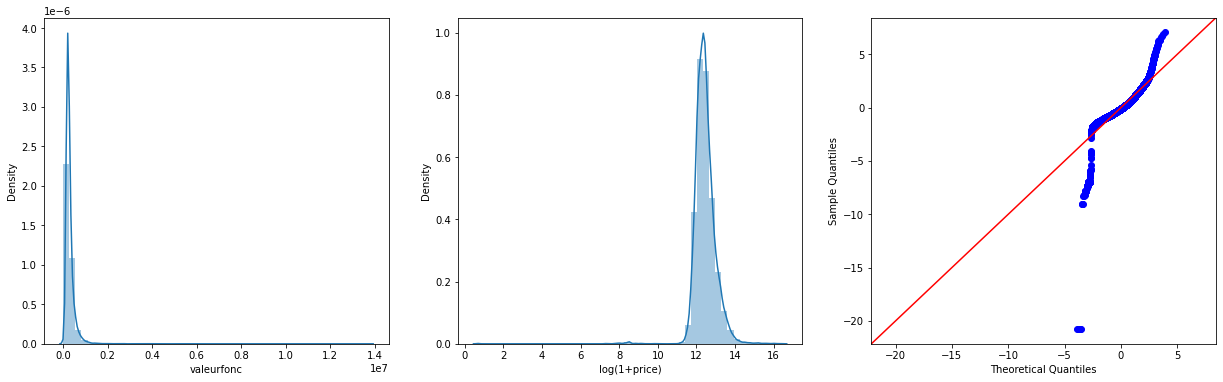

In [ ]:
# check distribution of price
fig, axes = plt.subplots(1,3, figsize=(21,6))
sns.distplot(df['valeurfonc'], ax=axes[0])
sns.distplot(np.log1p(df['valeurfonc']), ax=axes[1])
axes[1].set_xlabel('log(1+price)')
sm.qqplot(np.log1p(df['valeurfonc']), stats.norm, fit=True, line='45', ax=axes[2])
plt.show()

In [ ]:
# calculation about price_per_square
pd.set_option('display.float_format',lambda x : '%.2f' % x) # Cancel scientific notation

df['price_per_square'] = df['valeurfonc']/df['sbati']
result = df.groupby('coddep').agg({'price_per_square': ['mean', 'min', 'max']})
print("Mean, min, and max values of price_per_square grouped by department")
print(result)

Mean, min, and max values of price_per_square grouped by department
       price_per_square               
                   mean   min      max
coddep                                
75.00          10232.08 58.14 34888.89
77.00           3899.28 60.61 10952.38
78.00           4652.79 28.94 12500.00
91.00           3829.01  0.01  8947.37
92.00           6790.84  0.02 94805.09
93.00           4233.87  0.03 10782.10
94.00           5269.38 37.90 17754.25
95.00           3937.46 22.39  8846.15


In [ ]:
# filter outliers based on price_per_square
df = df[(df['price_per_square']>500)]
df = df[(df['price_per_square']<100000)]

# **Analysis of time series**

In [ ]:
# Creating another dataset so we can re-use the original if we need it
df_ = df.copy()
df_ = df.sort_values(by=['datemut'])

**Analysis by month**

In [ ]:
# resample the data by month
dfM = df_.resample('M').mean()

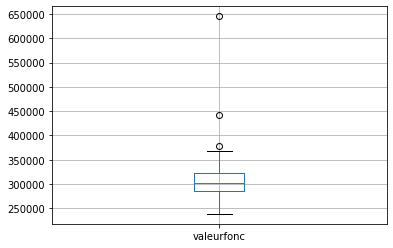

In [ ]:
# check the boxplot of average price by month
dfM.loc[:,['valeurfonc']].boxplot()

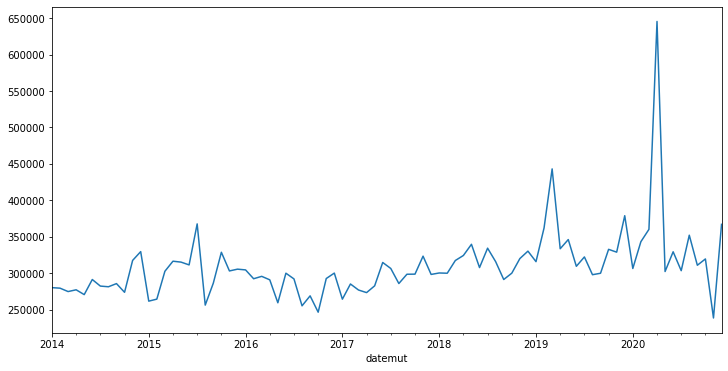

In [ ]:
# show the price change with the time
fig, ax = plt.subplots(figsize=(12,6))
dfM['valeurfonc'].plot()
plt.show()

**Analysis by department (by month and year)**

In [ ]:
# filter the 75 department
df_75 = df[df['coddep']==75]
df_75_M = df_75.resample('M').mean().dropna()
df_75_Y = df_75.resample('Y').mean()

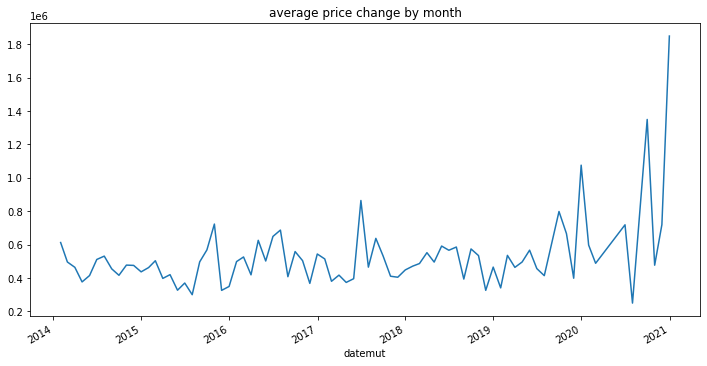

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
df_75_M['valeurfonc'].plot()
plt.title("average price change by month")
plt.show()

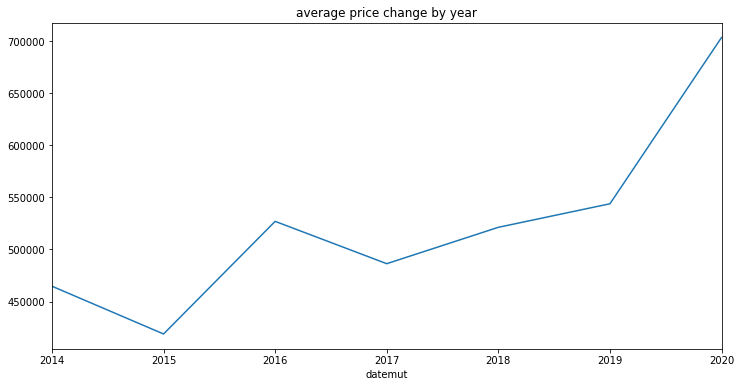

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
df_75_Y['valeurfonc'].plot()
plt.title("average price change by year")
plt.show()

**check seasonality**

In [ ]:
y_m_avg = df_75_M.groupby('datemut')['valeurfonc'].mean()
y_m_avg = y_m_avg.dropna()

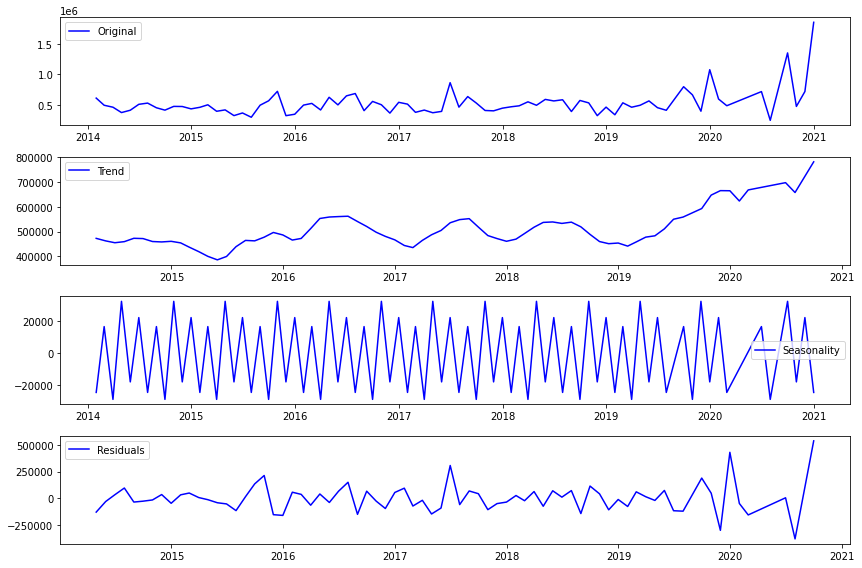

In [ ]:
decomposition = sm.tsa.seasonal_decompose(y_m_avg, model='additive', period=6)

#Gather the trend, seasonality, and residuals
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(y_m_avg, label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

**check stationarity**

In [ ]:
def stationarity_check(TS):
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=8, center=False).mean()
    roll_std = TS.rolling(window=8, center=False).std()
    
    # Perform the Dickey Fuller test
    dftest = adfuller(TS) 
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    std = plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

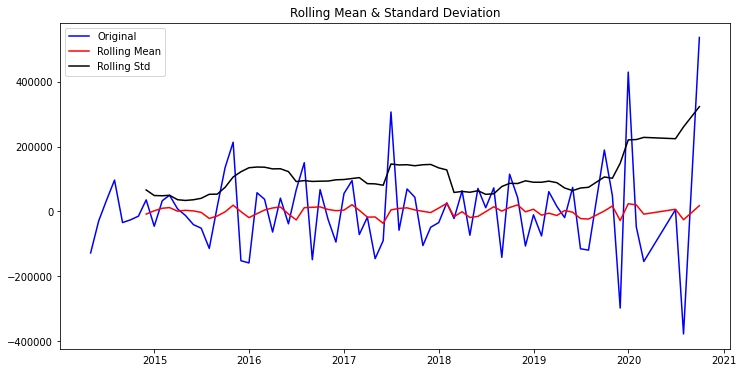

Results of Dickey-Fuller Test: 

Test Statistic                -4.49
p-value                        0.00
#Lags Used                    12.00
Number of Observations Used   60.00
Critical Value (1%)           -3.54
Critical Value (5%)           -2.91
Critical Value (10%)          -2.59
dtype: float64


In [ ]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
stationarity_check(ts_log_decompose)

In [ ]:
'''
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df_75.valeurfonc.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
'''

**check autocorrelation**

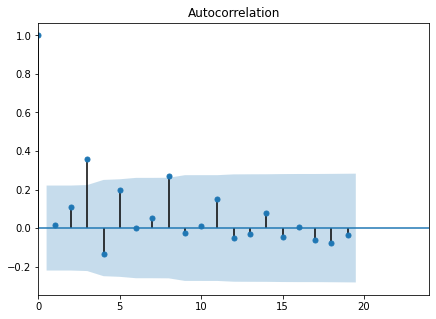

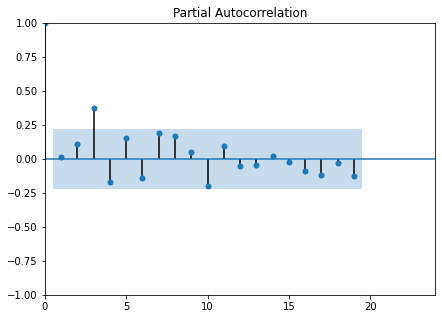

In [ ]:
# plot the auto correlation and PACF
rcParams['figure.figsize']=7,5
plot_acf(y_m_avg); plt.xlim(0,24); plt.show()
plot_pacf(y_m_avg); plt.xlim(0,24); plt.ylim(-1,1);plt.show()